In [25]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [26]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
import random

In [50]:
from MaaSSim.driver import driverEvent
from MaaSSim.traveller import travellerEvent
from datetime import timedelta

'''

Working with scheduled trips / to refactor
Ideas:
# scheduled time checked by platform/fleet
# better handling list of scheduled requests (maybe no need for set over that field)

'''


def f_match(**kwargs):
    """
    for each platfrom, whenever one of the queues changes (new idle vehicle or new unserved request)
    this procedure handles the queue and prepares transactions between drivers and travellers
    it operates based on nearest vehicle and prepares and offer to accept by traveller/vehicle
    :param kwargs:
    :return:
    """

    platform = kwargs.get('platform')  # platform for which we perform matching
    vehQ = platform.vehQ  # queue of idle vehicles
    reqQ = platform.reqQ  # queue of unserved requests
    schedQ = list(set(platform.schedQ))  # queue of scheduled requests
    reqQ += schedQ

    sim = platform.sim  # reference to the simulation object
    
    while min(len(reqQ), len(vehQ)) > 0:  # loop until one of queues is empty (i.e. all requests handled)
        
        # check if scheduled (30 minutes from now):
        for idx, request in sim.inData.requests.loc[reqQ].iterrows():
            if (request['tarr'] - sim.print_now()).total_seconds() / 3600 > 0.5:
                schedQ.append(idx)
                reqQ.pop(reqQ.index(idx))  # from the queues
                
        platform.schedQ = schedQ
        if len(reqQ) == 0:
            break
            
        requests = sim.inData.requests.loc[reqQ]  # queued schedules of requests
        vehicles = sim.vehicles.loc[vehQ]  # vehicle agents
        skimQ = sim.skims.ride[requests.origin].loc[vehicles.pos].copy().stack()  # travel times between
        # requests and vehicles in the column vector form

        skimQ = skimQ.drop(platform.tabu, errors='ignore')  # drop already rejected matches


        if skimQ.shape[0] == 0:
            sim.logger.warn("Nobody likes each other, "
                            "Qs {}veh; {}req; tabu {}".format(len(vehQ), len(reqQ), len(platform.tabu)))
            break  # nobody likes each other - wait until new request or new vehicle

        vehPos, reqPos = skimQ.idxmin()  # find the closest ones

        mintime = skimQ.min()  # and the travel time
        
        vehicle = vehicles[vehicles.pos == vehPos].iloc[0]
        veh_id = vehicle.name
        veh = sim.vehs[veh_id]  # vehicle agent

        request = requests[requests.origin == reqPos].iloc[0]
        req_id = request.name
        simpaxes = request.sim_schedule.req_id.dropna().unique()
        simpax = sim.pax[simpaxes[0]]  # first traveller of shared ride (he is a leader and decision maker)

        veh.update(event=driverEvent.RECEIVES_REQUEST)
        for i in simpaxes:
            sim.pax[i].update(event=travellerEvent.RECEIVES_OFFER)

        if simpax.veh is not None:  # the traveller already assigned (to a different platform)
            if req_id in platform.reqQ:  # we were too late, forget about it
                platform.reqQ.pop(platform.reqQ.index(req_id))  # pop this request (vehicle still in the queue)
        else:
            for i in simpaxes:
                offer_id = i
                pax_request = sim.pax[i].request
                if isinstance(pax_request.ttrav, int):
                    ttrav = pax_request.ttrav
                else:
                    ttrav = pax_request.ttrav.total_seconds()
                offer = {'pax_id': i,
                         'req_id': pax_request.name,
                         'simpaxes': simpaxes,
                         'veh_id': veh_id,
                         'status': 0,  # 0 -  offer made, 1 - accepted, -1 rejected by traveller, -2 rejected by veh
                         'request': pax_request,
                         'wait_time': mintime,
                         'travel_time': ttrav,
                         'fare': platform.platform.fare * sim.pax[i].request.dist / 1000}  # make an offer
                platform.offers[offer_id] = offer  # bookkeeping of offers made by platform
                sim.pax[i].offers[platform.platform.name] = offer  # offer transferred to
            if veh.f_driver_decline(veh=veh):  # allow driver reject the request
                veh.update(event=driverEvent.REJECTS_REQUEST)
                platform.offers[offer_id]['status'] = -2
                for i in simpaxes:
                    sim.pax[i].update(event=travellerEvent.IS_REJECTED_BY_VEHICLE)
                    sim.pax[i].offers[platform.platform.name]['status'] = -2
                sim.logger.warning("pax {:>4}  {:40} {}".format(request.name,
                                                             'got rejected by vehicle ' + str(veh_id),
                                                             sim.print_now()))
                platform.tabu.append((vehPos, reqPos))  # they are unmatchable
            else:
                for i in simpaxes:
                    if not sim.pax[i].got_offered.triggered:
                        sim.pax[i].got_offered.succeed()
                vehQ.pop(vehQ.index(veh_id))  # pop offered ones
                reqQ.pop(reqQ.index(req_id))  # from the queues
                
                while req_id in platform.schedQ:
                    platform.schedQ.pop(platform.schedQ.index(req_id))
        platform.updateQs()

In [64]:
from math import exp
from numpy.random.mtrand import choice

def f_platform_choice(*args, **kwargs):
    traveller = kwargs.get('traveller')
    sim = traveller.sim

    betas = sim.params.platform_choice
    offers = traveller.offers

    # calc utilities
    exps = list()
    for platform, offer in offers.items():

        u = offer['wait_time'] * betas.Beta_wait + \
            offer['fare'] * betas.Beta_cost

        exps.append(exp(u))
    
    sim.logger.info("exps: {}".format(exps))
    
    try:
        p = [_ / sum(exps) for _ in exps]
    except ZeroDivisionError:
        p = [1/len(exps)] * len(exps) # random selection
        
    platform_chosen = choice(list(offers.keys()), 1, p=p)[0]  # random choice with p

    if platform_chosen == -1:
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'chosen to opt out',
                                                     sim.print_now()))
    else:
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'chosen platform ' + str(platform_chosen),
                                                     sim.print_now()))
        # sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id, 'platform probs: ' + str(p),
                                                     # sim.print_now()))

    # handle requests
    for platform_id, offer in offers.items():
        if int(platform_id) == platform_chosen:
            sim.plats[platform_id].handle_accepted(offer['pax_id'])
        else:
            sim.plats[platform_id].handle_rejected(offer['pax_id'])
        sim.logger.info("pax {:>4}  {:40} {}".format(traveller.id,
                                                     "wait: {}, fare: {}".format(offer['wait_time'],int(offer['fare'] * 100) / 100),
                                                     sim.print_now()))
    return platform_chosen == -1


In [66]:
import pandas as pd

# def get_data_from_bq(sql_file):

#     with open(sql_file, "r") as f:
#         x = f.readlines()
#     sql = " ".join(x)
#     data = pd.read_gbq(sql, project_id="karhoo-production", dialect="standard")
#     return data

# df = get_data_from_bq('query.sql')

In [67]:
df = pd.read_csv("bq.csv", index_col=0)

In [68]:
df.head(2)

,quotes_list_id,organisation_id,fleet_id,vehicle_class,quote_type,currency,price_high_value,price_low_value,quote_predicted,quotes_list_complete,...,dropoff_latitude,dropoff_longitude,pickup_poi_name,pickup_poi_type,dropoff_poi_name,dropoff_poi_type,pickup_country,dropoff_country,pickup_point,dropoff_point
0,001ef94e-8855-11ec-acc5-f6689ec2684d,6fa00464-624e-462c-8024-242ef6cdd231,174977a1-d03c-4e8c-b622-059463bc73cc,saloon,FIXED,EUR,22.95,22.95,False,True,...,45.748511,4.825882,NaN,NaN,"Gare de Lyon-Perrache, Lyon, FR",TRAIN_STATION,NaN,FR,7393915,220288737
1,001ef94e-8855-11ec-acc5-f6689ec2684d,6fa00464-624e-462c-8024-242ef6cdd231,1f46083c-70ac-4601-9c99-3f4afeb79c06,saloon,FIXED,EUR,23.83,23.83,False,True,...,45.748511,4.825882,NaN,NaN,"Gare de Lyon-Perrache, Lyon, FR",TRAIN_STATION,NaN,FR,7393915,220288737


In [69]:
df["price_high_value"] = df["price_high_value"].astype("float")
df["price_low_value"] = df["price_low_value"].astype("float")
df["diff_to_picked"] = df["diff_to_picked"].astype("float")

In [70]:
general_prices = df[["fleet_id", "price_per_km"]].groupby(["fleet_id"]).median()
ever_converted_prices = df[df["quotes_list_id_flag"] == 1][["fleet_id", "price_per_km"]].groupby(["fleet_id"]).median()

In [71]:
# prepare city

from MaaSSim.utils import get_config, load_G, generate_platforms, generate_demand, generate_vehicles

params = MaaSSim.utils.get_config('../../data/config/Lyon.json')  # load configuration
inData = MaaSSim.utils.load_G(inData,params)  # load the graph for a different city

In [72]:
params.nP = len(df[df["quotes_list_id_flag"] == 1])
params.nV = 2 # unknown
params.nM = len(list(ever_converted_prices.values.reshape(-1)))

In [73]:
inData.platforms = generate_platforms(inData, params.nM)
inData.platforms.name = list(ever_converted_prices.index)
inData.platforms.fare = ever_converted_prices.values.reshape(-1)
inData.platforms.sample(3)

,fare,name,batch_time
id,,,
6,6.770,943f9979-e5ca-49cf-953b-194fa1f49717,None
4,6.985,3d708691-bd57-4a35-a443-f280c4700460,None
2,5.750,1f46083c-70ac-4601-9c99-3f4afeb79c06,None


In [74]:
inData.vehicles = generate_vehicles(inData, params.nV)
inData.vehicles.sample(3)

,pos,event,shift_start,shift_end,platform,expected_income
2,2026239409,driverEvent.STARTS_DAY,0,86400,1,NaN
14,192085395,driverEvent.STARTS_DAY,0,86400,7,NaN
4,206192614,driverEvent.STARTS_DAY,0,86400,2,NaN


In [75]:
from osmnx.distance import nearest_nodes, great_circle_vec

df["pickup_point"] = nearest_nodes(inData.G, df.pickup_longitude, df.pickup_latitude)
df["dropoff_point"] = nearest_nodes(inData.G, df.dropoff_longitude, df.dropoff_latitude)

inData = generate_demand(inData, params, avg_speed=True)
inData.passengers.pos = list(df[df["quotes_list_id_flag"] == 1]["pickup_point"])


In [76]:
for_dates = df[df["quotes_list_id_flag"] == 1]
treq = for_dates.apply(lambda x: pd.to_datetime(x["date_scheduled"]).tz_localize(None) if not pd.isnull(x["date_scheduled"]) else pd.to_datetime(x["booking_date"]).tz_localize(None), axis=1)


inData.requests.origin = list(df[df["quotes_list_id_flag"] == 1]["pickup_point"])
inData.requests.destination = list(df[df["quotes_list_id_flag"] == 1]["dropoff_point"])
inData.requests.tarr = list(treq)
inData.requests.treq = list(treq - pd.Timedelta(minutes=30))
inData.requests.ttrav = list(pd.to_timedelta(inData.requests.tarr - inData.requests.treq))
inData.requests.dist = inData.requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
inData.requests.sample(5)

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,ride_id,position,sim_schedule
153,153,36863014,3370328152,2021-12-03 11:50:00.000000,NaN,00:30:00,2021-12-03 12:20:00.000000,NaN,False,NaN,5551,NaN,NaN,NaN
14,14,3370328152,83650876,2021-11-29 09:41:00.000000,NaN,00:30:00,2021-11-29 10:11:00.000000,NaN,False,NaN,6346,NaN,NaN,NaN
192,192,3370328152,1787648748,2021-12-16 09:10:00.000000,NaN,00:30:00,2021-12-16 09:40:00.000000,NaN,False,NaN,5495,NaN,NaN,NaN
82,82,3370328152,1472874878,2021-11-29 09:21:00.000000,NaN,00:30:00,2021-11-29 09:51:00.000000,NaN,False,NaN,5677,NaN,NaN,NaN
196,196,23667053,36863014,2021-12-16 15:34:33.672182,NaN,00:30:00,2021-12-16 16:04:33.672182,NaN,False,NaN,3259,NaN,NaN,NaN


In [ ]:
params.simTime = 12
params.times.patience = 1e10

sim = MaaSSim.simulators.simulate(inData=inData, params=params, f_match=f_match, f_platform_choice=f_platform_choice)

11-02-22 12:40:36-WARNING-Setting up 12h simulation at 2021-11-14 15:24:00 for 2 vehicles and 246 passengers in ['Lyon']
11-02-22 12:40:36-INFO--------------------	Starting simulation	-------------------
11-02-22 12:40:36-INFO-exps: [1.300665969915815e-26, 5.242487098960265e-11, 1.51355826830773e-36, 8.240413963091758e-17, 1.5773643918649694e-36, 1.884695429262486e-24, 1.2443425868790795e-36, 1.988869931532327e-28, 1.2570764747856257e-19, 6.517846902599007e-44, 1.3012090359074959e-20, 5.3326700958123764e-33, 1.758002599140075e-46, 1.183864891267264e-26]
11-02-22 12:40:36-INFO-pax  134  chosen platform 1                        2021-11-14 15:24:15
11-02-22 12:40:36-INFO-pax  134  rejected vehicle 0                       2021-11-14 15:24:15
11-02-22 12:40:36-INFO-pax  134  wait: 432, fare: 18.22                   2021-11-14 15:24:15
11-02-22 12:40:36-INFO-pax  134  wait: 128, fare: 12.07                   2021-11-14 15:24:15
11-02-22 12:40:36-INFO-pax  134  rejected vehicle 4             

In [ ]:
import operator

nRIDES = [0] * len(inData.vehicles)
REVENUE = [0] * len(inData.vehicles)

for i in range(len(sim)):
    nRIDES = list(map(operator.add, nRIDES, list(sim[i].res[i].veh_exp["nRIDES"])))
    REVENUE = list(map(operator.add, REVENUE, list(sim[i].res[i].veh_exp["REVENUE"])))

kpis = pd.DataFrame(list(zip(nRIDES, REVENUE)), columns=["nRIDES", "REVENUE"])

In [ ]:
kpi_per_fleet  = pd.merge(inData.vehicles, kpis, left_index=True, right_index=True)
kpi_per_fleet  = pd.merge(kpi_per_fleet[['platform', 'REVENUE', 'nRIDES']].groupby("platform").sum(), inData.platforms, left_index=True, right_index=True)

In [ ]:
kpi_per_fleet[["REVENUE", "nRIDES", "name", "fare"]]

In [ ]:
df[df['quotes_list_id_flag'] == 1][["fleet_id", "price_high_value"]].groupby("fleet_id").sum()

In [22]:
df[df['quotes_list_id_flag'] == 1][["fleet_id", "price_high_value"]].groupby("fleet_id").count()

,price_high_value
fleet_id,
0561656d-284a-41de-a7a4-f6519a94b57c,3
174977a1-d03c-4e8c-b622-059463bc73cc,5
1f46083c-70ac-4601-9c99-3f4afeb79c06,12
322ad7b9-f077-4036-91ec-8d096d3e861a,5
3d708691-bd57-4a35-a443-f280c4700460,2
8f27bd23-732f-4239-9bcd-7da58223de64,4
943f9979-e5ca-49cf-953b-194fa1f49717,11
acca2209-3036-4697-a101-8e1da46ae908,9
b7f9fa8d-c735-49d2-acb6-470980003c3f,85


# old code

In [155]:
import pandas as pd

params = MaaSSim.utils.get_config('glance.json')  # load configuration
params.city = "Nootdorp, Netherlands" # modify it
inData = MaaSSim.utils.load_G(inData,params)  # load the graph for a different city

params.nP = 100 # change number of travellers
params.nV = 2
params.nM = 2
params.simTime = 5
params.times.patience = 2

inData = MaaSSim.utils.prep_supply_and_demand(inData, params)  # regenerate supply and demand
inData.platforms
# inData.requests['tarr'].iloc[0] = inData.requests['treq'].iloc[0] + pd.to_timedelta(3, unit='h')
# inData.requests['ttrav'].iloc[0] = inData.requests['treq'].iloc[0] - inData.requests['tarr'].iloc[0]
# print(inData.requests)

sim = MaaSSim.simulators.simulate(inData=inData, params=params, f_match=f_match, logger_level = logging.INFO)
# simulate with my user defined function



08-02-22 11:06:35-WARNING-Setting up 5h simulation at 2022-02-08 08:41:53 for 2 vehicles and 100 passengers in Nootdorp, Netherlands
08-02-22 11:06:35-INFO--------------------	Starting simulation	-------------------
08-02-22 11:06:36-INFO-pax    0  got to dest at                           2022-02-08 08:50:12
08-02-22 11:06:36-INFO-pax    2  got to dest at                           2022-02-08 08:50:26
08-02-22 11:06:36-INFO-pax    1  got to dest at                           2022-02-08 08:50:27
08-02-22 11:06:36-INFO-pax    3  got to dest at                           2022-02-08 08:53:55
08-02-22 11:06:36-INFO-pax    5  got to dest at                           2022-02-08 08:54:47
08-02-22 11:06:36-INFO-pax    4  got to dest at                           2022-02-08 08:56:12
08-02-22 11:06:36-INFO-pax    6  got to dest at                           2022-02-08 09:00:25
08-02-22 11:06:36-INFO-pax    7  got to dest at                           2022-02-08 09:02:37
08-02-22 11:06:36-INFO-pax    8 

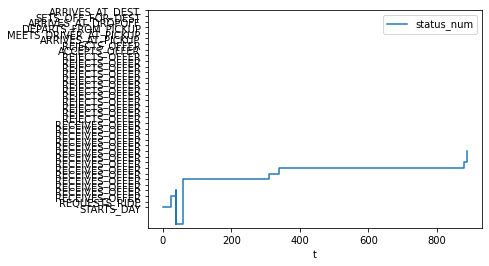

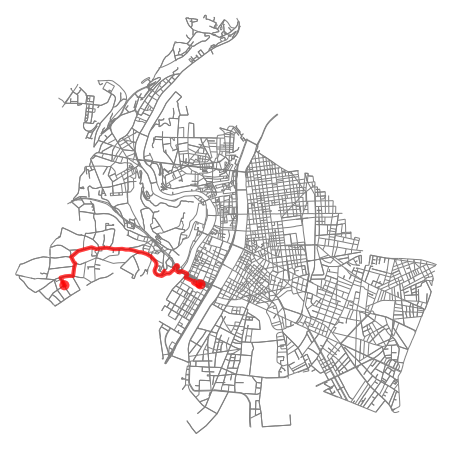

In [18]:
trip_id = 1
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation
sim.plot_trip(trip_id)

In [19]:
raw

,pax,pos,t,event,veh_id
0,1,7393915,0,STARTS_DAY,NaN
1,1,7393915,24,REQUESTS_RIDE,NaN
2,1,7393915,24,RECEIVES_OFFER,NaN
3,1,7393915,24,RECEIVES_OFFER,NaN
4,1,7393915,24,RECEIVES_OFFER,NaN
5,1,7393915,24,RECEIVES_OFFER,NaN
6,1,7393915,24,RECEIVES_OFFER,NaN
7,1,7393915,24,RECEIVES_OFFER,NaN
8,1,7393915,24,RECEIVES_OFFER,NaN
9,1,7393915,24,RECEIVES_OFFER,NaN
